In [104]:
#TP1 - KMeans

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import hdbscan
import math
#import random

from scipy.io import arff
from enum import Enum

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs


In [10]:
# Tools functions (Extraction, preparation, filter, plot, ...)
PATH = "artificial/"
name_file = "banana.arff"

def extractData(path_file):
    """
    load file and return desired data
    """
    return arff.loadarff(open(path_file,'r'))[0]

data = extractData(PATH+name_file)

def prepareData(data):
    """
    From array(numpy.void) to array(features) 
    """
    # Find number of features of data
    i=-1
    for feat in data[0]: i=i+1
    nb_features = i
    
    # Create an array(features) <=> array(array(feature)) 
    X = []
    for elem in data:
        point = [elem[i] for i in range(nb_features)]
        X.append(point)
    return X

def filterNoise(X,labels,filter_value=-1):
    """
    Return a list X and associated label filtered from label = filter_value
    """
    new_X = []
    new_labels = []
    for i,label in enumerate(labels):
        if(label!=filter_value):
            new_X.append(X[i])
            new_labels.append(labels[i])      
    return new_X,new_labels

def showClusters(X,labels,title):
    """
    Plot cluster labeled with colors
    """
    fig = plt.figure()

    if(np.shape(X)[1]==2): # 2D
        xs = [point[0] for point in X]
        ys = [point[1] for point in X]

        plt.scatter(xs,ys,s=10,c=labels,cmap="rainbow")
        plt.show()  
    elif(np.shape(X)[1]==3): # 3D
        ax = fig.add_subplot(projection='3d')

        xs = [point[0] for point in X]
        ys = [point[1] for point in X]
        zs = [point[2] for point in X]

        ax.scatter(xs,ys,zs,s=10,c=labels,cmap='rainbow')
        ax.set_title(title)
        plt.show()
    else:
        print("Impossible to plot more than 3D graph")
    
def showGridClusters(X,lst_labels,lst_names,name="My graph"):
    """
    Plot a grid of cluster labeled with colors
    """
    n_plot = np.shape(lst_labels)[0]
    n_features = np.shape(X)[1]
    
    n_row = math.ceil(n_plot/2)
    n_col = 2
    grid = plt.GridSpec(n_row, n_col*2, wspace=0.4, hspace=0.3)



    for i,labels in enumerate(lst_labels):
        if(n_features==2): # 2D
            ax = plt.subplot(grid[math.floor(i/n_row),i%n_col])   

            xs = [point[0] for point in X]
            ys = [point[1] for point in X]
            print([math.floor(i/n_row),i%n_col])
            ax.scatter(xs,ys,s=10,c=labels,cmap="rainbow")
            ax.set_title(lst_names[i])

        elif(n_features==3): # 3D     
            ax = plt.subplot(grid[math.floor(i/n_row),i%n_col],projection="3d")  

            xs = [point[0] for point in X]
            ys = [point[1] for point in X]
            zs = [point[2] for point in X]

            ax.scatter(xs,ys,zs,s=10,c=labels,cmap="rainbow")
            ax.set_title(lst_names[i])

    plt.title(name)
    plt.show()  




In [11]:
# Metrics
class MetricType(Enum):
    Silhouette=1
    DaviesBouldin=2
    
def getScoreClustering(X,labels,metric_type:MetricType,args=None):
    """
    Switch of methods depending on metric_type
    Return score 
    """
    def getScoreSilhouette(X,labels,args=None):
        return metrics.silhouette_score(X, labels, metric='euclidean')

    def getScoreDaviesBouldin(X,labels,args):
        return - metrics.davies_bouldin_score(X, labels)
    
    switcher = {
        MetricType.Silhouette: getScoreSilhouette,
        MetricType.DaviesBouldin: getScoreDaviesBouldin
    }
    # Get the function from switcher dictionary
    func = switcher.get(metric_type, lambda: "Invalid metric type")
    # Execute the function
    return func(X,labels,args)
    

In [12]:
# KMeans
def findBestParametersKMeans(X,lst_n_clusters:int,metric_type:int,verbose=False):
    """
    Loop into lst_n_clusters to find best n_cluster for KMeans  
    """
    # Set best score and index
    best_score = -float('inf')
    index_best = None
    
    # Loop into different values of n_clusters 
    for i,n_clusters in enumerate(lst_n_clusters):
        if verbose: print("{}%".format((i/np.size(lst_n_clusters))*100)) # percent print at each step
        kmeans = KMeans(n_clusters=n_clusters,init='k-means++').fit(X) # Clustering algo
        score =  getScoreClustering(X, kmeans.labels_, metric_type) # update score
        if(score>best_score): # save best score index
            best_score = score
            index_best = i
            
    return lst_n_clusters[index_best]

def makeKMeans(X,metric_type:int,display=False,verbose=False):
    """
    Find best clustering with KMeans
    """
    # Create list of possible number of clusters
    lst_n_clusters = [i for i in range(2,MAX_N_CLUSTERS)]
    
    # Find best parameters
    best_n_clusters = findBestParametersKMeans(X,lst_n_clusters,metric_type,verbose)
    
    # Print best solution
    print("Best match is {} clusters".format(best_n_clusters))
    kmeans = KMeans(n_clusters=best_n_clusters,init='k-means++').fit(X) 
    if display: showClusters(X,kmeans.labels_,"KMeans") # Display solution
    return kmeans.labels_

In [13]:
# AgglomerativeClustering        
def findBestParametersAgglomerativeClustering(X,lst_n_clusters,metric_type:MetricType,linkage:str,verbose=False):
    """
    Loop into lst_n_clusters to find best n_cluster for AgglomerativeClustering 
    """
    # Set best score and index
    best_score = -float('inf')
    index_best = None
    
    # Loop into different values of n_clusters 
    for i,n_clusters in enumerate(lst_n_clusters):
        if verbose: print("{}%".format((i/np.size(lst_n_clusters))*100)) # percent print at each step
        clustering = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage).fit(X)# Clustering algo
        score =  getScoreClustering(X, clustering.labels_, metric_type)# update score
        if(score>best_score):# save best score index
            best_score = score
            index_best = i
            
    return lst_n_clusters[index_best]

def makeAgglomerativeClustering(X,metric_type:MetricType,display=False,verbose=False):
    """
    Find best clustering with AgglomerativeClustering for each linkage
    """
    # Create list of possible linkage and n_clusters
    linkage_list  = ["ward","complete","average","single"]
    lst_n_clusters = [i for i in range(2,MAX_N_CLUSTERS)]
    
    # Loop into and find best n_clusters for each linkage
    lst_labels = []
    for linkage in linkage_list:
        # Find best parameters
        best_n_clusters = findBestParametersAgglomerativeClustering(X,lst_n_clusters,metric_type,linkage,verbose)
        
        # print best solution for given linkage
        print("Best match is {} clusters  [linkage = {}, metrics = {}] ".format(best_n_clusters,linkage,metric_type)) 
        clustering = AgglomerativeClustering(n_clusters=best_n_clusters,linkage=linkage).fit(X)
        lst_labels.append(clustering.labels_)
        if(verbose): print("Clustering done for {}".format(linkage))


    if display: showGridClusters(X,lst_labels,linkage_list,"AgglomerativeClustering")   # Display best solution for each linkage
        
    return clustering

In [14]:
# DBSCAN
def findBestParametersDBSCAN(X,lst_eps,lst_min_n_samples,metric_type:MetricType,verbose=False):
    """
    Loop into lst_eps and lst_min_n_samples to find best eps and n_samples for DBSCAN 
    """
    # Set best score and index
    best_score = -float('inf')
    index_best_eps = None
    index_best_min_n_samples = None
    
    # Loop into different values of eps and n_samples 
    for i,eps in enumerate(lst_eps):
        if verbose: print(f'{(i/(np.size(lst_eps)))*100}%') # percent print at each step of eps
        for j,min_n_samples in enumerate(lst_min_n_samples):
            clustering = DBSCAN(min_samples=min_n_samples,eps=eps).fit(X) # Clustering algo
            if(len(set(clustering.labels_))>2): # If 2 clusters
                #new_X,new_labels = filter_list(X,clustering.labels_)
                score = getScoreClustering(X, clustering.labels_, metric_type)# update score
                if(score>best_score):# save best score index
                    best_score = score
                    index_best_eps = i
                    index_best_min_n_samples = j
                        
    return lst_eps[index_best_eps],lst_min_n_samples[index_best_min_n_samples]

def makeDBSCAN(X,metric_type:MetricType,display=True,verbose=False):
    """
    Find best clustering with DBSCAN
    """
    # Create list of possible linkage and n_clusters
    lst_eps = np.arange(START_EPS,END_EPS,STEP_EPS)
    lst_min_n_samples = [i for i in range(1,MAX_MIN_N_SAMPLES)]

    # find best eps and min_n_samples 
    best_eps,best_nb_samples = findBestParametersDBSCAN(X,lst_eps,lst_min_n_samples,metric_type,verbose)


    # print best solution for given linkage
    print(f'Best clustering with nb_samples = {best_nb_samples} and eps = {best_eps}')
    dbscan =  DBSCAN(min_samples=best_nb_samples,eps=best_eps).fit(X)
    if display: showClusters(X,dbscan.labels_,"DBSCAN")   # Display solution 
    
    return dbscan.labels_

In [15]:
# HDBSCAN
def findBestParametersHDBSCAN(X,lst_min_size_cluster,metric_type:MetricType,verbose=False):
    """
    Loop into lst_min_size_cluster to find best min_size_cluster for HDBSCAN  
    """
    # Set best score and index
    best_score = -float('inf')
    index_best = None
    
    # Loop into different values of n_clusters 
    for i,min_size_cluster in enumerate(lst_min_size_cluster):
        if verbose: print("{}%".format((i/np.size(lst_min_size_cluster))*100)) # percent print at each step
        hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_size_cluster).fit(X) # Clustering algo
        score =  getScoreClustering(X, hdbscan.labels_, metric_type) # update score
        if(score>best_score): # save best score index
            best_score = score
            index_best = i
            
    return lst_min_size_cluster[index_best]

def makeHDBSCAN(X,metric_type:MetricType,display=True,verbose=False):
        """
        Find best clustering with KMeans
        """
        # Create list of possible number of clusters
        lst_min_cluster_size = [i for i in range(2,MAX_MIN_CLUSTER_SIZE)]

        # Find best parameters
        best_min_cluster_size = findBestParametersKMeans(X,lst_min_cluster_size,metric_type,verbose)

        # Print best solution
        print("Best match with min_cluster_size = {}".format(best_min_cluster_size))
        hdbscan = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size).fit(X) # Clustering algo
        if display: showClusters(X,hdbscan.labels_,"HDBSCAN") # Display solution
        return hdbscan.labels_

In [16]:
class ClusteringType(Enum):
    KMeans=1
    AgglomerativeClustering=2
    DBSCAN=3
    HDBSCAN=4
    
# Choose clustering
def makeClustering(name_file:str,clustering_type:ClusteringType,metric_type:MetricType,
                       display:bool=True,verbose:bool=False):     
    # Extract data
    data = extractData(name_file)
    
    # Prepare data
    X = prepareData(data)

    
    switcher_algo = {
        ClusteringType.KMeans: makeKMeans,
        ClusteringType.AgglomerativeClustering: makeAgglomerativeClustering,
        ClusteringType.DBSCAN: makeDBSCAN,
        ClusteringType.HDBSCAN: makeHDBSCAN
    }
    # Get the function from switcher_algo dictionary
    algo = switcher_algo.get(clustering_type, lambda: "Invalid clustering type")
    
    # Execute the function
    start_time = time.time()
    labels = algo(X,metric_type,display,verbose) ###
    end_time =time.time()
    
    print(f'{clustering_type} with {metric_type}')
    print("--- %s seconds ---" % (end_time - start_time))
    return labels

In [17]:
for metric in MetricType: print(metric)
print()
for algo_name in ClusteringType: print(algo_name)

MetricType.Silhouette
MetricType.DaviesBouldin

ClusteringType.KMeans
ClusteringType.AgglomerativeClustering
ClusteringType.DBSCAN
ClusteringType.HDBSCAN


Best match is 8 clusters


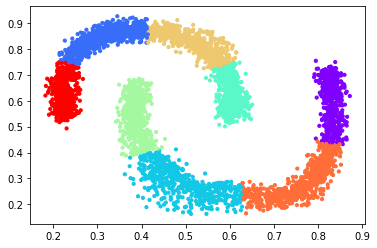

ClusteringType.KMeans with MetricType.Silhouette
--- 23.150786638259888 seconds ---
Best match is 10 clusters


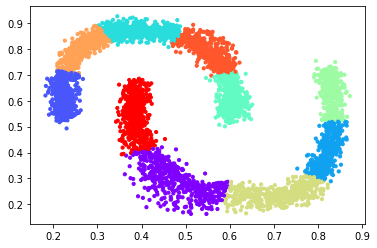

ClusteringType.KMeans with MetricType.DaviesBouldin
--- 9.099008083343506 seconds ---
Best match is 2 clusters


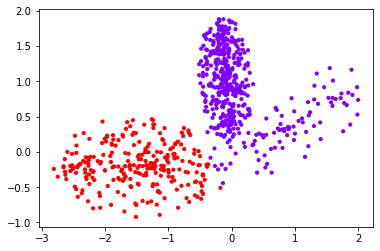

ClusteringType.KMeans with MetricType.Silhouette
--- 5.133091926574707 seconds ---
Best match is 2 clusters


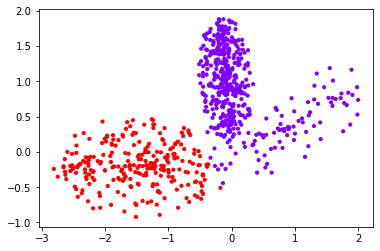

ClusteringType.KMeans with MetricType.DaviesBouldin
--- 4.647181034088135 seconds ---
Best match is 29 clusters


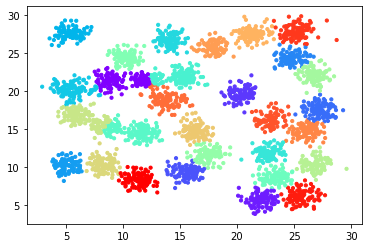

ClusteringType.KMeans with MetricType.Silhouette
--- 13.305041790008545 seconds ---
Best match is 30 clusters


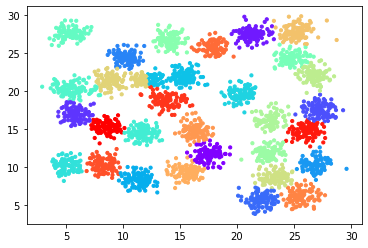

ClusteringType.KMeans with MetricType.DaviesBouldin
--- 6.908583402633667 seconds ---
Best match is 29 clusters


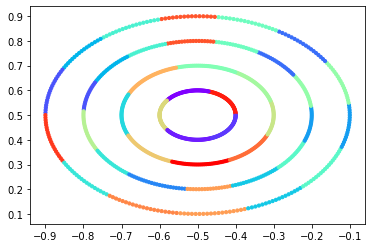

ClusteringType.KMeans with MetricType.Silhouette
--- 6.5155768394470215 seconds ---
Best match is 11 clusters


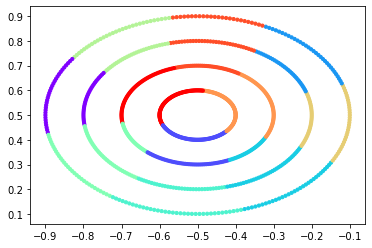

ClusteringType.KMeans with MetricType.DaviesBouldin
--- 5.3843207359313965 seconds ---
Best match is 3 clusters


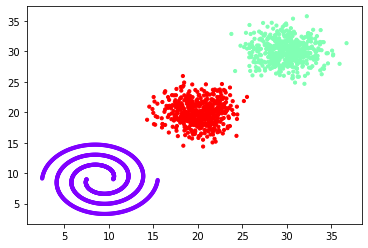

ClusteringType.KMeans with MetricType.Silhouette
--- 8.652314186096191 seconds ---
Best match is 3 clusters


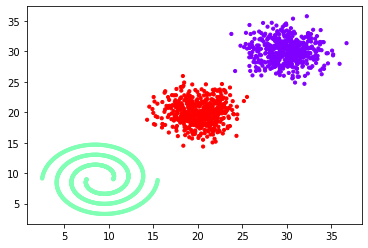

ClusteringType.KMeans with MetricType.DaviesBouldin
--- 5.9115190505981445 seconds ---


array([1, 1, 1, ..., 0, 0, 0])

In [19]:
# CONSTANTS Clustering
MAX_N_CLUSTERS = 31 # KMeans and Agglomerative Clustering

PATH = "artificial/"
# KMeans
type_clustering = ClusteringType.KMeans

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

0.0%
50.0%
Best match is 3 clusters  [linkage = ward, metrics = MetricType.Silhouette] 
Clustering done for ward
0.0%
50.0%
Best match is 2 clusters  [linkage = complete, metrics = MetricType.Silhouette] 
Clustering done for complete
[0, 0]


IndexError: index 1 is out of bounds for axis 0 with size 1

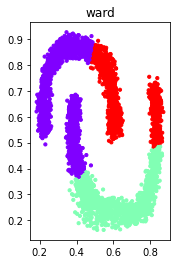

In [84]:
# CONSTANTS Clustering
MAX_N_CLUSTERS = 4 # KMeans and Agglomerative Clustering

PATH = "artificial/"
# Agglomerative Clustering
type_clustering = ClusteringType.AgglomerativeClustering

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

In [ ]:
# CONSTANTS Clustering
START_EPS,END_EPS,STEP_EPS = 0.01,3,0.1 # Only DBSCAN
MAX_MIN_N_SAMPLES = 50

PATH = "artificial/"
# DBSCAN
type_clustering = ClusteringType.DBSCAN

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

KeyboardInterrupt: 

In [ ]:
# CONSTANTS Clustering
MAX_MIN_CLUSTER_SIZE = 50 # Only HDBSCAN

PATH = "artificial/"
# HDBSCAN
type_clustering = ClusteringType.HDBSCAN

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

0.0%
2.083333333333333%
4.166666666666666%
6.25%
8.333333333333332%
10.416666666666668%
12.5%
14.583333333333334%
16.666666666666664%
18.75%
20.833333333333336%
22.916666666666664%
25.0%
27.083333333333332%
29.166666666666668%
31.25%
33.33333333333333%
35.41666666666667%
37.5%
39.58333333333333%
41.66666666666667%
43.75%
45.83333333333333%
47.91666666666667%
50.0%
52.083333333333336%
54.166666666666664%
56.25%
58.333333333333336%
60.416666666666664%
62.5%
64.58333333333334%
66.66666666666666%
68.75%
70.83333333333334%
72.91666666666666%
75.0%
77.08333333333334%
79.16666666666666%
81.25%
83.33333333333334%
85.41666666666666%
87.5%
89.58333333333334%
91.66666666666666%
93.75%
95.83333333333334%
97.91666666666666%
Best match with min_cluster_size = 8


UnboundLocalError: local variable 'hdbscan' referenced before assignment